# Plan
1. Brief data overview
2. Masks
3. Score evaluation
4. Run-lenght encoding
5. Work on synthetic data first

Notes: Goog looking ships: 1, 69
Strange cases: 15
Multiple ships: 1460 - 1464

In [1]:
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
import cv2

In [5]:
DATA_PATH = 'data'
TRAIN_DATA = os.path.join(DATA_PATH, 'train')

some_img_name = df.loc[1]['ImageId']
some_img_path = os.path.join(TRAIN_DATA, some_img_name)
some_img = imageio.imread(some_img_path)

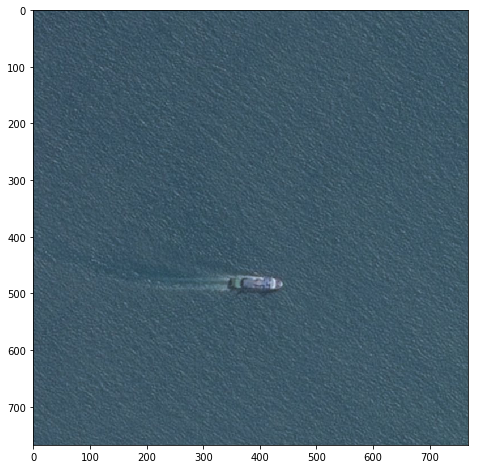

In [6]:
plt.figure(figsize = (8,8))
plt.imshow(some_img)
plt.show()

## 1. Brief data overview

Airbus Ship Detection Challenge data (total 26GB) consists of following files:

 - train.zip: ~104k training images. RGB .jpg files of size 768x768 px.
 - test.zip: ~88k test images. RGB .jpg files of size 768x768 px.
 - train_ship_segmentation.csv: ships' masks (from train set) encoded in specific way
 - sample_submission.csv: 
 - test_ship_segmentation.csv: WHY ???

In [2]:
df = pd.read_csv(DATA_PATH + '/train_ship_segmentations.csv')
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [3]:
df.shape

(131030, 2)

In [4]:
imgs = df['ImageId'].unique().size
imgs_without_ships = df['EncodedPixels'].isna().sum(axis=0)

print("There are {} imgs in which {} have no ships in it".format(imgs, imgs_without_ships))

There are 104070 imgs in which 75000 have no ships in it


## Number of ships distribution

In [7]:
df_with_ships = df.loc[~df['EncodedPixels'].isna()]
df_imgId_count = df_with_ships.groupby(['ImageId']).size().reset_index(name='count')

series_count = df_imgId_count['count'].value_counts()
series_count.loc[0] = imgs_without_ships
series_count = series_count.sort_index()

count_values = series_count.values
values = np.linspace(0, 15, 16)

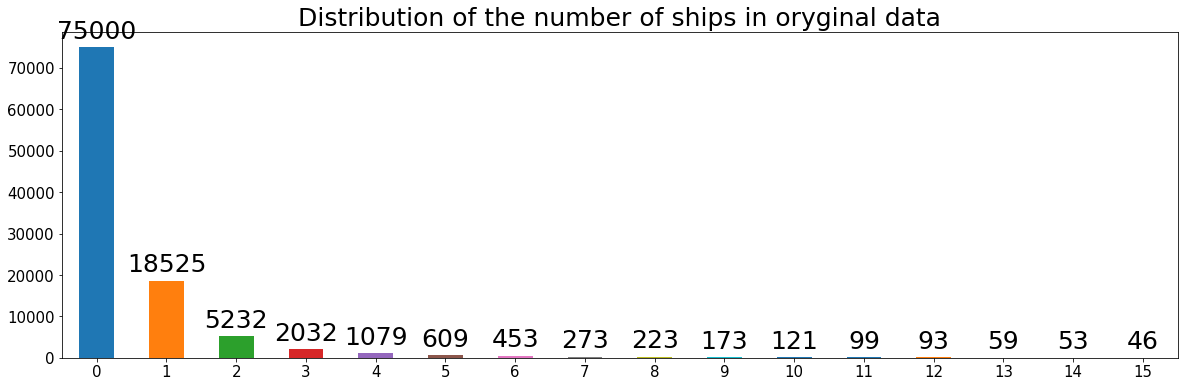

In [8]:
plt.figure(figsize=(20,6))
ax = series_count.plot(kind='bar')

plt.xticks(rotation=0, fontsize = 15)
plt.yticks(rotation=0, fontsize = 15)

rects = ax.patches

# Make some labels.
labels = [series_count[i] for i in range(16)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1000, label,
            ha='center', va='bottom', fontsize=25)

plt.title('Distribution of the number of ships in oryginal data', fontsize=25)
plt.show()

## Data is highly inhomogeneus

# Images and masks

In [10]:
some_img_name = df.loc[1]['ImageId']
some_img_path = os.path.join(TRAIN_DATA, some_img_name)
some_img = imageio.imread(some_img_path)
print("Each image has the shape {}".format(some_img.shape))

Each image has the shape (768, 768, 3)


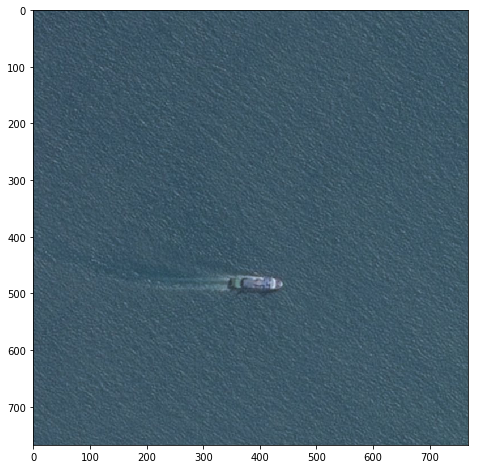

In [11]:
plt.figure(figsize = (8,8))
plt.imshow(some_img)
plt.show()

In [12]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 255
    return img.reshape(shape).T  # Needed to align to RLE direction

In [16]:
some_img_mask_rle = df.loc[1]['EncodedPixels']
some_img_mask = rle_decode(some_img_mask_rle)

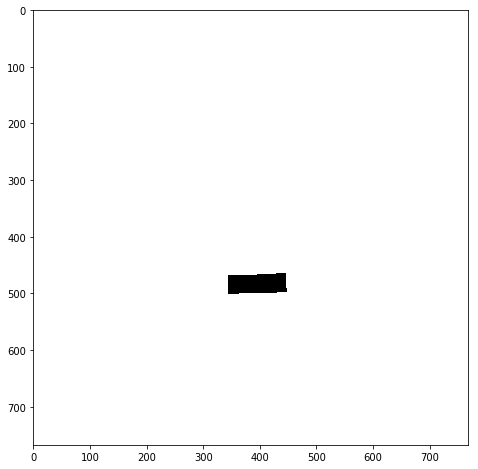

In [17]:
plt.figure(figsize = (8,8))
plt.imshow(some_img_mask, cmap='binary')
plt.show()

In [14]:
def mask_overlay(image, mask):
    """
    Helper function to visualize mask
    """
    mask = mask.astype(np.uint8)
    mask_stacked = np.stack((np.zeros_like(mask), mask, np.zeros_like(mask)), -1)
    weighted_sum = cv2.addWeighted(mask_stacked, 0.75, image, 0.5, 0.)
    img = image.copy()
    ind = mask_stacked[:, :, 1] > 0    
    img[ind] = weighted_sum[ind]
    return img

In [19]:
final_img = mask_overlay(some_img, some_img_mask)

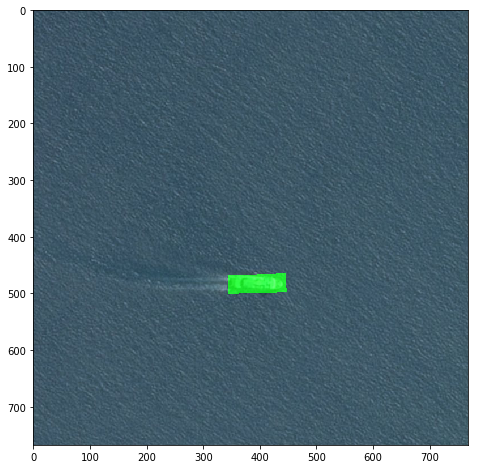

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(final_img)
plt.show()

# Miltiple ships case

In [11]:
index = 1460

some_img_name = df.loc[index]['ImageId']
some_img_path = os.path.join(TRAIN_DATA, some_img_name)
some_img = imageio.imread(some_img_path)
some_img.shape

(768, 768, 3)

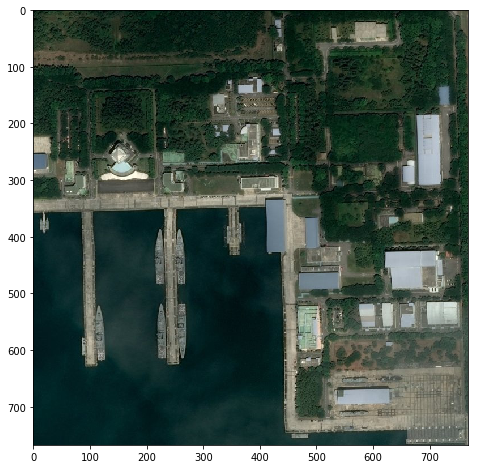

In [12]:
plt.figure(figsize = (8,8))
plt.imshow(some_img)
plt.show()

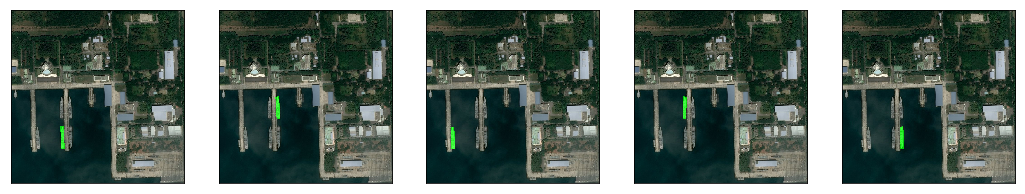

In [27]:
fix, axes = plt.subplots(1, 5, figsize = (18, 8), subplot_kw={'xticks': [], 'yticks': []})

index = 1460

for ax in axes.flat:
    some_img_mask_rle = df.loc[index]['EncodedPixels']
    some_img_mask = rle_decode(some_img_mask_rle)
    final_img = mask_overlay(some_img, some_img_mask)
    ax.imshow(final_img)
    index += 1
plt.show()

**Recall!** Each mask coressponds to the different entry in `train_ship_segmentations.csv`

In [42]:
df[1459:1466].head(10)

,ImageId,EncodedPixels
1459,02bc480c5.jpg,458265 1 459032 4 459800 6 460567 8 461334 11 ...
1460,02bcca2d6.jpg,167943 25 168711 74 169479 99 170247 99 171015...
1461,02bcca2d6.jpg,191620 10 192388 30 193156 50 193924 69 194692...
1462,02bcca2d6.jpg,84235 25 85003 73 85771 98 86539 98 87307 98 8...
1463,02bcca2d6.jpg,165507 98 166275 98 167043 98 167811 98 168579...
1464,02bcca2d6.jpg,196360 25 197128 73 197896 98 198664 98 199432...
1465,02bce2ddd.jpg,NaN


# Score evluation

## Method: F2 Score at different intersection over union (IoU) thresholds


$$IoU(A, B) = \frac{A\cap B}{A \cup B}$$

The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95)

t - fixed threshold (t = 0.6 or t = 0.8 for example)

$$F_2(t) = \frac{5\cdot TP(t)}{5\cdot TP(t) +4\cdot FN(t) + FP(t) }$$

### Note: FPs are not penalised as FNs, thus it is better to have some redundant masks rather then miss ships.

### Objective:  Create or find a function that computes IoU for encoded masks

### Image score

$$\frac{1}{10}\sum_t F_2(t)$$

### The final score is just the mean from all images

# Run-lenght encoding

The pixels are one-indexed and numbered from top to bottom, then left to right: 1 is pixel (1,1), 2 is pixel (2,1), etc.

In [33]:
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


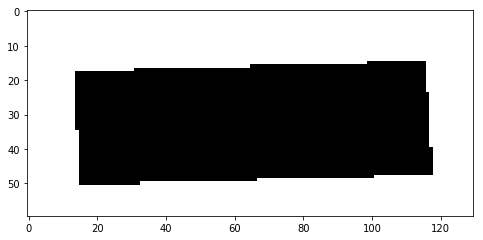

'264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339154 33 339922 33 340690 33

In [48]:
some_img_mask_rle = df.loc[1]['EncodedPixels']
some_img_mask = rle_decode(some_img_mask_rle)
some_img_mask_zoomed = some_img_mask[450: 510, 330: 460]
plt.figure(figsize=(8,8))
plt.imshow(some_img_mask_zoomed, cmap='binary')
plt.show()
df.loc[1]['EncodedPixels']